In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

# Goal : 
Objective is to select the best fertilizer for different weather, soil conditions and crops.

# Evaluation:
Submissions are evaluated according to the Mean Average Precision @ 3 (MAP@3):

#  Feature Explanations:

* Temparature : 	The current or average soil/air temperature (likely in °C). Affects crop and nutrient uptake.
* Humidity : Atmospheric humidity (%). High humidity can influence soil moisture and fertilizer needs.
* Moisture : 	Soil moisture content (%). Crucial for determining water stress and nutrient absorption.
* Soil Type : Type of soil (e.g., Clayey, Sandy, red, Black, etc.). Different soils have different nutrient retention     and drainage properties.
* Crop Type : Type of crop being grown (e.g., Sugarcane, Millets, Barley, etc.). Each crop has specific nutrient          requirements.
* Nitrogen : 	Current nitrogen content in the soil. Essential for leaf growth and protein synthesis.
* Potassium : Current potassium content in the soil. Vital for water regulation and enzyme activation.
* Phosphorous : Current phosphorous content in the soil. Important for root development and energy transfer.
* Fertilizer Name : The recommended fertilizer (e.g., Urea, DAP, 14-35-14, etc.). This is the target column to predict.

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test_data = pd.read_csv("/kaggle/input/playground-series-s5e6/test.csv")
original_data = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")
submission_data = pd.read_csv("/kaggle/input/playground-series-s5e6/sample_submission.csv")

In [3]:
print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("original_data shape :",original_data.shape)
print("submission_data shape :",submission_data.shape)

train_data shape : (750000, 10)
test_data shape : (250000, 9)
original_data shape : (100000, 9)
submission_data shape : (250000, 2)


In [4]:
train_data.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [5]:
train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)
train_data = pd.concat([train_data, original_data], ignore_index=True)
train_data = train_data.drop_duplicates()
print("shape of the data :",train_data.shape)

shape of the data : (850000, 9)


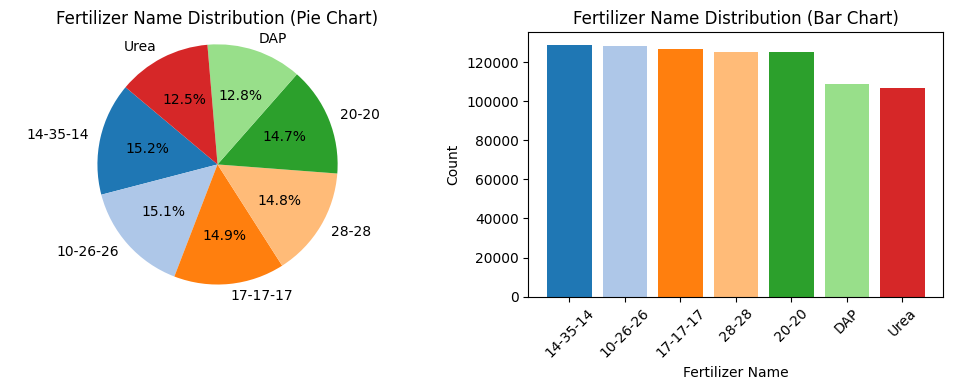

In [6]:
# Count fertilizer names
fert_counts = train_data['Fertilizer Name'].value_counts()
fert_names = fert_counts.index
fert_values = fert_counts.values

# Generate matching colors
colors = plt.cm.tab20.colors[:len(fert_names)]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Pie chart
axes[0].pie(fert_values, labels=fert_names, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title("Fertilizer Name Distribution (Pie Chart)")
axes[0].axis('equal')

# Bar chart
axes[1].bar(fert_names, fert_values, color=colors)
axes[1].set_title("Fertilizer Name Distribution (Bar Chart)")
axes[1].set_xlabel("Fertilizer Name")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

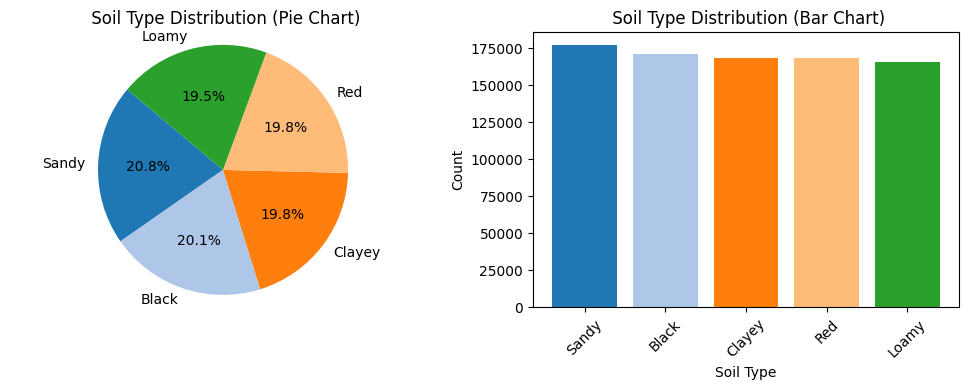

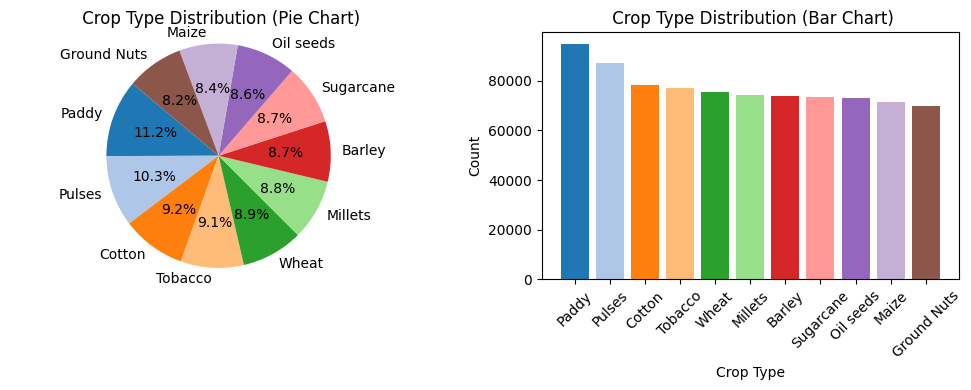

In [7]:
# Define a helper function
def plot_pie_bar(column_name, title_prefix=""):
    counts = train_data[column_name].value_counts()
    labels = counts.index
    values = counts.values
    colors = plt.cm.tab20.colors[:len(labels)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Pie chart
    axes[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[0].set_title(f"{title_prefix}{column_name} Distribution (Pie Chart)")
    axes[0].axis('equal')

    # Bar chart
    axes[1].bar(labels, values, color=colors)
    axes[1].set_title(f"{title_prefix}{column_name} Distribution (Bar Chart)")
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plot for Soil Type
plot_pie_bar('Soil Type', title_prefix=" ")

# Plot for Crop Type
plot_pie_bar('Crop Type', title_prefix=" ")

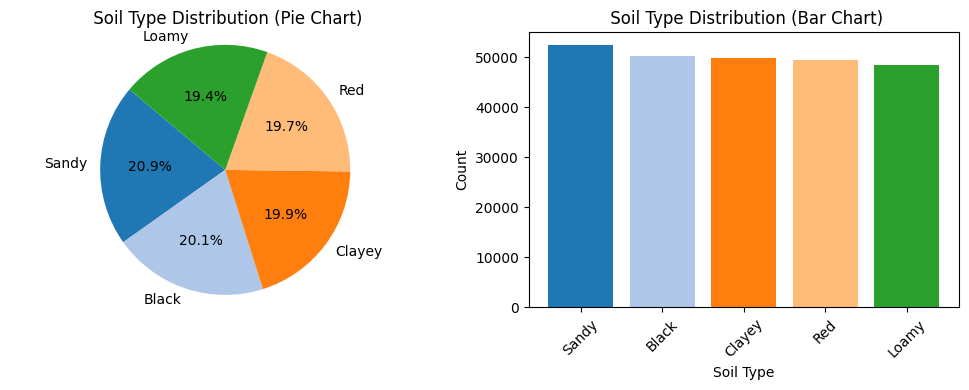

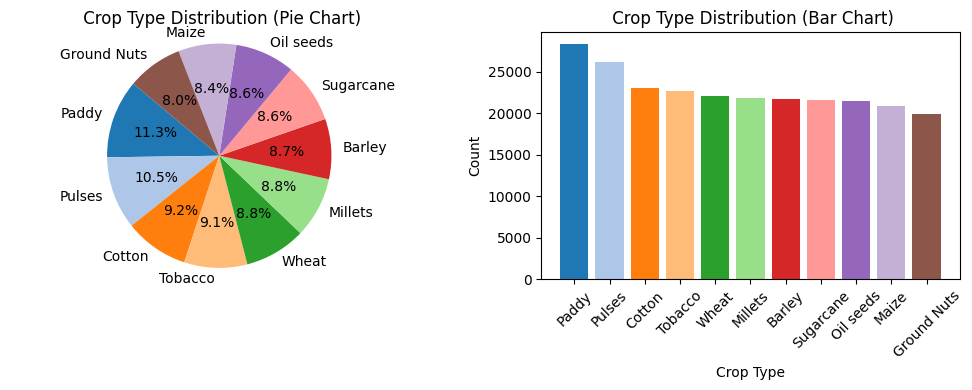

In [8]:
# Define a helper function
def plot_pie_bar(column_name, title_prefix=""):
    counts = test_data[column_name].value_counts()
    labels = counts.index
    values = counts.values
    colors = plt.cm.tab20.colors[:len(labels)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Pie chart
    axes[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    axes[0].set_title(f"{title_prefix}{column_name} Distribution (Pie Chart)")
    axes[0].axis('equal')

    # Bar chart
    axes[1].bar(labels, values, color=colors)
    axes[1].set_title(f"{title_prefix}{column_name} Distribution (Bar Chart)")
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Plot for Soil Type
plot_pie_bar('Soil Type', title_prefix=" ")

# Plot for Crop Type
plot_pie_bar('Crop Type', title_prefix=" ")

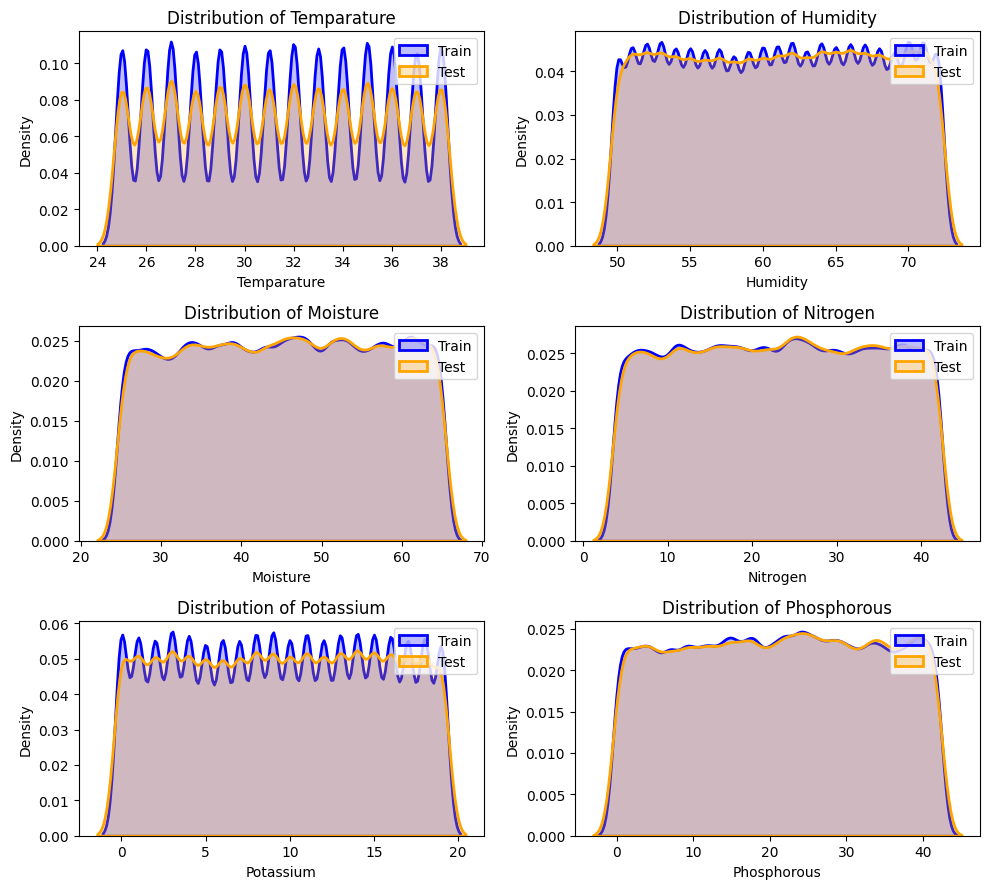

In [9]:
# Identify numeric columns
num_cols = train_data.select_dtypes(include='number').columns

# Set up the layout
n_cols = 2
n_rows = (len(num_cols) + 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(train_data[col], label='Train', fill=True, color='blue', linewidth=2)
    sns.kdeplot(test_data[col], label='Test', fill=True, color='orange', linewidth=2)
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#train_data = train_data.drop('id', axis = 1)
num_cols = list(train_data.select_dtypes(exclude=['object','category']).columns)
cat_cols = list(train_data.select_dtypes(include=['object','category']).columns.difference(['Fertilizer Name']))

num_cols_test = list(test_data.select_dtypes(exclude=['object','category']).columns)
cat_cols_test = list(test_data.select_dtypes(include=['object','category']).columns)

len(num_cols),len(cat_cols), len(num_cols_test), len(cat_cols_test)

(6, 2, 6, 2)

In [11]:
from sklearn.preprocessing import OrdinalEncoder
# Categorical columns
cat_cols = ['Soil Type', 'Crop Type']

# Initialize LabelEncoder for categorical columns
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    train_data[col] = label_encoders[col].fit_transform(train_data[col])
    test_data[col] = label_encoders[col].transform(test_data[col])

#oe = OrdinalEncoder()
#train_data[cat_cols] = oe.fit_transform(train_data[cat_cols])
#test_data[cat_cols] = oe.transform(test_data[cat_cols])

# Encode the target separately
target_le = LabelEncoder()
train_data['Fertilizer Name'] = target_le.fit_transform(train_data['Fertilizer Name'])


def feature_engineering(train_data, test_data):

    # ==========================
    # 1. Interaction & Derived Features
    # ==========================
    for df in [train_data, test_data]:
        df['N_to_P'] = df['Nitrogen'] / (df['Phosphorous'] + 1e-5)
        df['N_to_K'] = df['Nitrogen'] / (df['Potassium'] + 1e-5)
        df['P_to_K'] = df['Phosphorous'] / (df['Potassium'] + 1e-5)
        df['Total_NPK'] = df['Nitrogen'] + df['Phosphorous'] + df['Potassium']
        df['Climate_Index'] = (df['Temparature'] + df['Humidity']) / 2
        df['Water_Stress'] = df['Humidity'] - df['Moisture']

    # ==========================
    # 2. Group-Based Features (on already-encoded 'Crop Type')
    # ==========================
    crop_group_means = train_data.groupby('Crop Type')[['Nitrogen', 'Phosphorous', 'Potassium']].mean()

    for df in [train_data, test_data]:
        df['Crop_N_mean'] = df['Crop Type'].map(crop_group_means['Nitrogen'])
        df['Crop_P_mean'] = df['Crop Type'].map(crop_group_means['Phosphorous'])
        df['Crop_K_mean'] = df['Crop Type'].map(crop_group_means['Potassium'])

    return train_data, test_data

train_data, test_data = feature_engineering(train_data, test_data)
train_data.shape, test_data.shape

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols_test] = scaler.transform(test_data[num_cols_test])

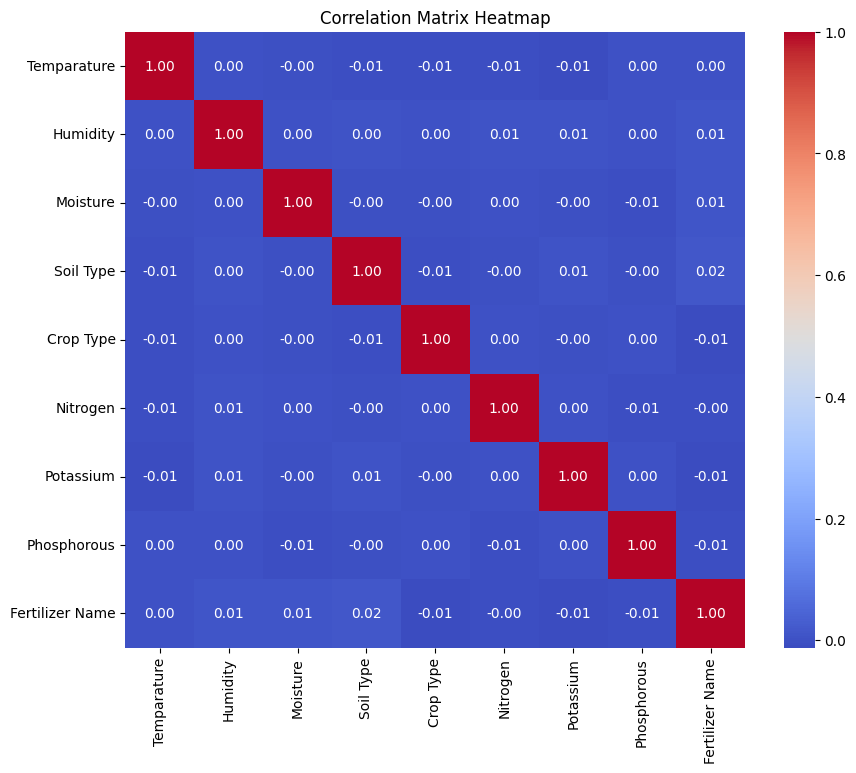

In [13]:
# Get correlation matrix (default is Pearson correlation)
correlation_matrix = train_data.corr()
# Display
#print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [14]:
# Number of classes
num_classes = len(target_le.classes_)
num_classes

7

# Splitting Data:

In [15]:
X = train_data.drop('Fertilizer Name',axis = 1)
y = train_data["Fertilizer Name"]
test = test_data.copy()

# XGBClassifier:

In [16]:
parameters = {'n_estimators': 936, 'booster': 'gbtree', 'lambda': 0.016474561392450647, 'alpha': 0.13627367351454978, 'colsample_bytree': 0.4929682927659898, 'subsample': 0.9711492175907754, 'learning_rate': 0.0726447774822523, 'max_depth': 10, 'min_child_weight': 5}
#value: 0.36463313725503316.

In [17]:
params = {'max_depth':12,'colsample_bytree':0.467,'subsample':0.86,'n_estimators':4000,'learning_rate':0.03,'gamma':0.26,'max_delta_step':4,'reg_alpha':2.7,'reg_lambda':1.4,'early_stopping_round':100}
#value : 0.3677

from sklearn.preprocessing import label_binarize
import numpy as np
# Define custom MAP@3 function
def map3(actual, predicted_proba, k=3):
    actual_bin = label_binarize(actual, classes=np.arange(num_classes))
    top_k_preds = np.argsort(predicted_proba, axis=1)[:, ::-1][:, :k]
    score = 0.0
    for i in range(len(actual)):
        if actual[i] in top_k_preds[i]:
            rank = np.where(top_k_preds[i] == actual[i])[0][0]
            score += 1 / (rank + 1)
    return score / len(actual)

FOLDS = 20
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
xgb_scores = []
oof = np.zeros(shape = (len(train_data) ,y.nunique()))
pred_prob = np.zeros(shape = (len(test_data),y.nunique()))


xgb_model = XGBClassifier(**params,objective='multi:softprob',num_class=num_classes,
                            eval_metric='mlogloss',
                            use_label_encoder=False,
                            random_state=42)

for i, (train_idx, valid_idx) in enumerate(skf.split(X,y)):
    x_train, x_valid = X.iloc[train_idx],X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx],y.iloc[valid_idx]

    xgb_model.fit(x_train,y_train, eval_set=[(x_valid,y_valid)],verbose = 0)
    proba = xgb_model.predict_proba(x_valid)
    oof[valid_idx] = xgb_model.predict_proba(x_valid)
    pred_prob +=xgb_model.predict_proba(test)

    score = map3(y_valid.values, proba)
    xgb_scores.append(score)

    top_3_preds = np.argsort(oof[valid_idx], axis=1)[:, -3:][:, ::-1]  
    actual = [[label] for label in y_valid]

np.mean(xgb_scores)

top_3_preds = np.argsort(pred_prob, axis=1)[:, -3:][:, ::-1]
top_3_labels = target_le.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

submission = pd.DataFrame({
    'id': submission_data.id,
    'Fertilizer Name': [' '.join(row) for row in top_3_labels]
})
submission.to_csv('submission.csv', index=False)
submission.head()

In [18]:
def mapk(y_true, y_pred, k=3):
    N = len(y_true)
    scores = []
    for true, preds in zip(y_true, y_pred):
        score = 0.0
        found = False
        for i, p in enumerate(preds[:k], start=1):
            if p in true and not found:
                score = 1.0 / i
                found = True
                break
        scores.append(score)
    return np.mean(scores)

In [19]:
import xgboost as xgb

def map3_scorer(y_true, y_pred_probs):
    y_true_wrapped = [[int(lbl)] for lbl in y_true]
    top3 = np.argsort(-y_pred_probs, axis=1)[:, :3].tolist()
    return mapk(y_true_wrapped, top3, 3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
map3_scores = []
test_preds = np.zeros(shape = (len(test_data),y.nunique()))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = xgb.XGBClassifier(**params,objective='multi:softprob',random_state=13,enable_categorical=True,tree_method='hist',device = "cuda")
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    val_probs = model.predict_proba(X_val)
    score = map3_scorer(y_val, val_probs)
    map3_scores.append(score)

    # Predict on test set
    test_preds += model.predict_proba(test) / skf.n_splits 
    print(f"Fold {fold} MAP@3: {score:.4f}")

print(f"\nMean MAP@3 across 5 folds: {np.mean(map3_scores):.4f}")

Fold 1 MAP@3: 0.3684
Fold 2 MAP@3: 0.3679
Fold 3 MAP@3: 0.3684
Fold 4 MAP@3: 0.3678
Fold 5 MAP@3: 0.3662

Mean MAP@3 across 5 folds: 0.3677


In [20]:
top_3_preds = np.argsort(test_preds, axis=1)[:, -3:][:, ::-1]
top_3_labels = target_le.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

submission = pd.DataFrame({
    'id': submission_data.id,
    'Fertilizer Name': [' '.join(row) for row in top_3_labels]
})
submission.to_csv('submission1.csv', index=False)
submission.head()

,id,Fertilizer Name
0,750000,10-26-26 DAP 20-20
1,750001,17-17-17 10-26-26 20-20
2,750002,20-20 28-28 Urea
3,750003,14-35-14 DAP 17-17-17
4,750004,Urea 20-20 10-26-26


model.fit(X, y)
test_preds = model.predict_proba(test)
top_3_preds = np.argsort(test_preds, axis=1)[:, -3:][:, ::-1]
top_3_labels = target_le.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

submission = pd.DataFrame({
    'id': submission_data.id,
    'Fertilizer Name': [' '.join(row) for row in top_3_labels]
})
submission.to_csv('submission2.csv', index=False)
submission.head()